In [519]:
import numpy as np
import sympy as sp
from IPython.display import display
from itertools import permutations
from copy import deepcopy

from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import StatevectorSimulator
import networkx as nx

from scipy.optimize import minimize
from MSA_class import MultipleSequenceAlignment

In [520]:
def get_Aer_backend(name: str):
    """Function for retrieving specified Aer backend
    Possible backends include:
    
    "aer_simulator", "aer_simulator_statevector","aer_simulator_density_matrix",
    "aer_simulator_stabilizer","aer_simulator_matrix_product_state",
    "aer_simulator_extended_stabilizer","aer_simulator_unitary",
    "aer_simulator_superop","qasm_simulator,statevector_simulator",
    "unitary_simulator","pulse_simulator"

    Parameters:
    -----------
        name: string - name of chosen Aer qiskit backend

    Returns:
    --------
        my_backend: qiskit.providers.aer.backends - chosen backend
    """
    return Aer.get_backend(name)

def compute_Q_edges(Q: np.ndarray) -> np.ndarray:
    """ Function for computing edges from Q matrix in QUBO
    
    Parameters:
    -----------
        Q: np.ndarray - 2D numpy array containing weights in Q matrix from QUBO
    
    Returns:
    --------
       edges: np.ndarray - 1D numpy array of triplets np.array([(i_1,j_1,w_i1j1),(i_2,j_2,w_i2j2),...])

    """

    edges = [] 
    for idx1 in range(Q.shape[1]):
        for idx2 in range(Q.shape[0]):
            if Q[idx1][idx2] != 0:
                edges.append((idx1,idx2,Q[idx1][idx2]))
    return edges

def string_to_arr(string: str) -> np.ndarray:
    """Funtion for transforming given string of integers
       to corresponding array of ints

    Parameters:
    -----------
        string: str - a string of ints, e.g.: '001100'   

    Returns:
    --------
        arr: np.ndarray - numpy array of ints, e.g.: np.array([0,0,1,1,0,0])
    """

    arr = []
    for str in string: arr.append(int(str))
    return np.array(arr).reshape((len(np.array(arr)),1))
    


In [521]:
def create_qaoa_circ(my_MSA, theta, normalize_weights=True):
    
    """
    Creates a parametrized qaoa circuit

    """
    letters_in_mat = [my_MSA.initial_MSA[i][j] for i in range(my_MSA.initial_MSA.shape[0]) 
                      for j in range(my_MSA.initial_MSA.shape[1]) if my_MSA.initial_MSA[i][j] != "_"]
    
    nqubits = int(len(letters_in_mat) *  my_MSA.initial_MSA.shape[1])  # Number of qubits = number of nodes in graph 
    p       = len(theta)//2                                            # Number of alternating unitaries
    qc      = QuantumCircuit(nqubits)                                  # Initializing Q circuit w. nqubits nr. of qbits

    beta  = theta[:p]                # Beta opt param for mixing unitaries as first p vals.
    gamma = theta[p:]                # Gama opt param for cost unitaries as last p vals.
    
    p1, p2, p3 = my_MSA.penalties[0],  my_MSA.penalties[1],  my_MSA.penalties[2]

    Q, h, d    = my_MSA.QUBO_model[0], my_MSA.QUBO_model[1], my_MSA.QUBO_model[2]

    if normalize_weights:
        Q *= 1./np.max(np.array([np.max(Q),np.max(h)]))
        h *= 1./np.max(np.array([np.max(Q),np.max(h)]))

    edges = compute_Q_edges(Q)

    # Initial_state: Hadamark gate on each qbit
    for i in range(0, nqubits):
        qc.h(i)
    
    # Cost unitary:
    for irep in range(0, p):        
        for i, j, w_ij in edges:
            if i!= j:
                qc.rzz(2 * gamma[irep] * w_ij , i , j)
            else:
                qc.rz(2 * gamma[irep] * w_ij      , i) # Diagonal in Q matrix
                qc.rz(2 * gamma[irep] * h[i] * p1 , i) # Elements of h vector

    # Mixer unitary: X rotation on each qbit      
    for irep in range(0, p): 
        for i in range(0, nqubits):
            qc.rx(1 * beta[irep], i)
            
    qc.measure_all()        
    return qc

def compute_expectation(my_MSA: np.ndarray, counts) -> float:
    
    """
    Computes expectation value based on measurement results

    """
    Q, h, d = my_MSA.QUBO_model[0], my_MSA.QUBO_model[1], my_MSA.QUBO_model[2]
    sum_count, avg = 0, 0
    for bitstring, count in counts.items():
        state = string_to_arr(bitstring)
        score = ((state.T @ (Q @ state)) + (h.T @ state) + d)[0][0]
        avg  += score * count
        sum_count += count
    return avg/sum_count

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(my_MSA: np.ndarray, p: int, normalize_weights = True, shots=512):
    
    """
    Runs parametrized circuit
    
    """
    #backend = StatevectorSimulator(precision="double")
    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(my_MSA, theta, normalize_weights=normalize_weights)
        #qc = qc.decompose()
        #qc = transpile(qc,optimization_level=3)
        counts = backend.run(qc,seed_simulator=10).result().get_counts()
        return compute_expectation(my_MSA,counts) ## Returns the expectation of graph, given counts
    
    return execute_circ

In [522]:
my_strings   = np.array(["AG","G"])
my_penalties = np.array([1,1,1])
my_msa       = MultipleSequenceAlignment(strings = my_strings, penalties = my_penalties) 

In [523]:
shots = 512
p = 6
get_expectation(my_MSA = my_msa, p = p, normalize_weights=True, shots = shots)

<function __main__.get_expectation.<locals>.execute_circ(theta)>

In [524]:
shots = 512
p = 6
expectation = get_expectation(my_MSA = my_msa, p = p, normalize_weights=True, shots = shots)
options = {"disp":True,"maxiter": 1000}
res = minimize(fun = expectation, x0 = np.ones(p), method='COBYLA',options = options)
res

     fun: -0.53759765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([ 1.12577636,  0.59386694,  0.82384775,  2.09762814,  2.04881407,
       -0.05087526])


   Normal return from subroutine COBYLA

   NFVALS =   58   F =-5.375977E-01    MAXCV = 0.000000E+00
   X = 1.125776E+00   5.938669E-01   8.238478E-01   2.097628E+00   2.048814E+00
      -5.087526E-02


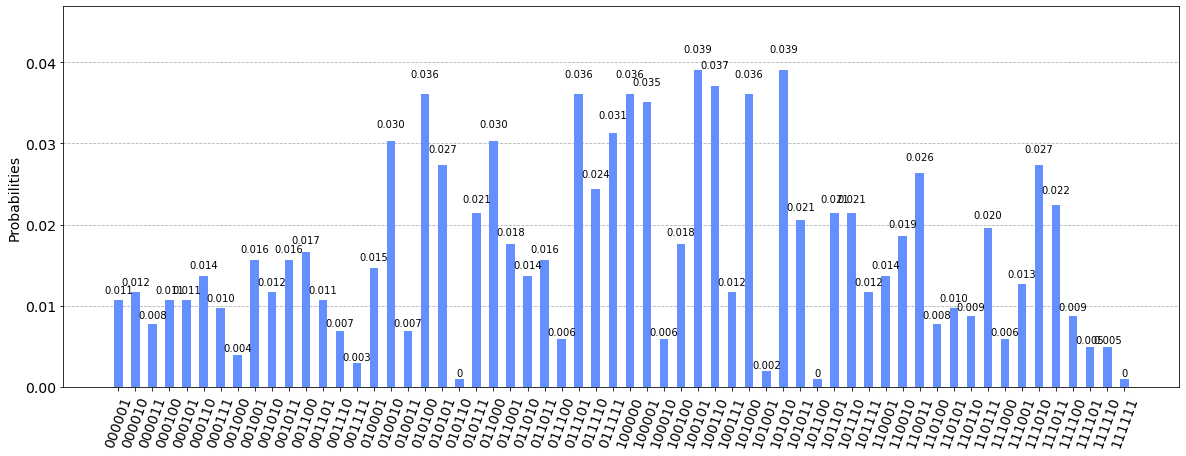

In [525]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
#backend = StatevectorSimulator(precision="double")
backend.shots = shots

qc = create_qaoa_circ(my_MSA=my_msa,theta = res.x, normalize_weights=True)
#qc = qc.decompose()
#qc = transpile(qc,optimization_level=3)

counts = backend.run(qc,seed_simulator=10).result().get_counts()
plot_histogram(counts,figsize=(20,7))

In [526]:
def get_solutions(lim: int, counts):
    idxs = np.flip(np.argsort(list(counts.values())))
    return np.array(list(counts.keys()))[idxs][:lim]

best_solutions = get_solutions(len(list(counts.values())),counts)
states = [string_to_arr(solution) for solution in best_solutions]
idx = 0
print(states[idx])
print(my_msa.bit_state_2_matrix(states[idx]))

[[1]
 [0]
 [1]
 [0]
 [1]
 [0]]
[['G' '_']
 ['G' '_']]


In [527]:
def cost_eval(my_MSA,theta):
    qc = create_qaoa_circ(my_MSA, theta, normalize_weights=True)
    #qc = qc.decompose()
    #qc = transpile(qc,optimization_level=3)
    counts = backend.run(qc,seed_simulator=10).result().get_counts()
    return compute_expectation(my_MSA,counts) ## Returns the expectation of graph, given counts


In [528]:
cost_eval(my_msa,[1,1])

-0.44677734375

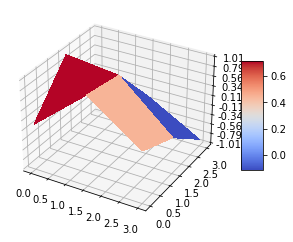

In [531]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.linspace(0, 3, 3)
Y = np.linspace(0, 3, 3)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [532]:
X


array([[0. , 1.5, 3. ],
       [0. , 1.5, 3. ],
       [0. , 1.5, 3. ]])

In [533]:
Y

array([[0. , 0. , 0. ],
       [1.5, 1.5, 1.5],
       [3. , 3. , 3. ]])

In [534]:
Z

array([[ 0.        ,  0.99749499,  0.14112001],
       [ 0.99749499,  0.85225051, -0.21091343],
       [ 0.14112001, -0.21091343, -0.89168225]])

In [535]:
final_Z = []
for col in range(Y.shape[1]):
    row_Z = []
    for row in range(X.shape[0]):
        cur_x, cur_y = X[row][col], Y[row][col]
        row_Z.append(np.sin(np.sqrt(cur_x**2+cur_y**2)))
    final_Z.append(row_Z)
np.array(final_Z)

    

array([[ 0.        ,  0.99749499,  0.14112001],
       [ 0.99749499,  0.85225051, -0.21091343],
       [ 0.14112001, -0.21091343, -0.89168225]])